<span style="font-size: 48px; font-weight: bold;">Autorski algorytm EA testowany na zbiorze CIFAR-10</span>

Spis treści

- [1](#1)- Zainstalowanie wymaganych pakietów
- [2](#2) - Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow
- [3](#3) - Załadowanie danych
- [4](#4) - Ocena zbalansowania zbioru
- [5](#5) - Normalizacja danych
- [6](#6)- Zdefiniowanie CNN
- [7](#7) - Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametróww słowniku
- [8](#8) - Zdefiniowa funkcji celu
- [9](#9) - Wykonujemy proces optymalizacji bayesowskiej za pomocą algorytmu EA w wersji podstawowej i zapis oraz wyświetlenie najlepszych wyników
- [10](#10) - Ocena modelu na zbiorze testowym

### <a name='1'></a> 1. Zainstalowanie wymaganych pakietów

In [148]:
# !pip install scikit-learn
# !pip install scikit-optimize
# !pip install keras
# !pip install numpy

### <a name="2"></a> 2. Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow

In [149]:
import itertools
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D,MaxPooling2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [150]:
import time

### <a name="3"></a> 3.Załadowanie danych


In [151]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [152]:
y_train = y_train.flatten() 
y_test = y_test.flatten()

### <a name="4"></a> 4.Ocena zbalansowania zbioru

Text(0, 0.5, 'Number of images')

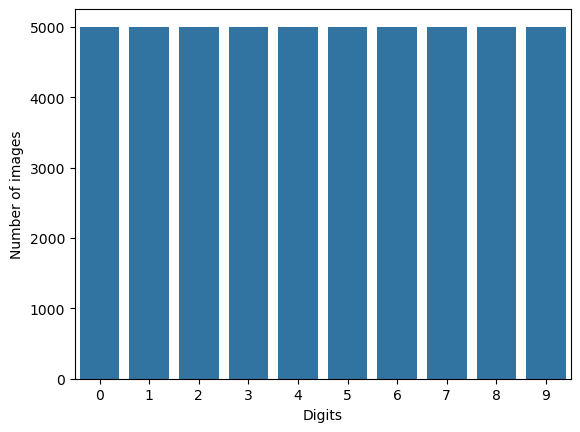

In [153]:
g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

### <a name="5"></a> 5. Normalizacja danych

In [154]:
X_train = X_train / 255.0
X_test = X_test / 255.0


y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

### <a name="6"></a> 6.Zdefiniowanie CNN

In [155]:
def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    num_conv_layers,
    filter_size,
    kernel_size,
    activation,
):
    """
    Hiperparametry:
    learning_rate: Współczynnik uczenia dla optymalizatora.
    num_dense_layers: Liczba warstw gęstych (dense).
    num_dense_nodes: Liczba neuronów w każdej warstwie gęstej.
    num_conv_layers: Liczba warstw konwolucyjnych
    filter_size: Liczba filtrów w warstwach konwolucyjnych.
    kernel_size: Rozmiar kernela.
    activation: Funkcja aktywacji dla wszystkich warstw.
    """

    model = Sequential()

    
    for i in range(num_conv_layers):
        filters = filter_size + (15*i)
        model.add(Conv2D(kernel_size=kernel_size, strides=1, filters=filter_size, padding='same',
                     activation=activation))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Dropout(0.25))

    model.add(Flatten()) 

    for i in range(num_dense_layers):

        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))


    model.add(Dense(10, activation='sigmoid')) 
    
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

### <a name="7"></a> 7.Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametróww słowniku

In [156]:
param_grid = {
    "learning_rate": (1e-6, 1e-2),
    "num_dense_layers": (1, 5),
    "num_dense_nodes": (10, 500),
    "num_conv_layers": (2, 5),
    "filter_size": [16, 32, 64, 128],
    "kernel_size": [(3, 3), (5, 5), (7, 7)],
    "activation": ["relu", "sigmoid"]
}

### <a name="8"></a> 8.Zdefiniowa zminnych globalnych

In [157]:
# model zapisany pod nazwą
path_best_model = 'cnn_model.h5'

# punkt startowy dla optymalizacji
best_accuracy = 0



### <a name=""></a> 9. Wykonujemy proces optymalizacji bayesowskiej za pomocą algorytmu EA w wersji podstawowej i zapis oraz wyświetlenie najlepszych wyników



In [158]:
class Individual():
    """Klasa reprezentująca pojedyńczego osobnika,
        przechowuje wszystkie jego cechy"""
    def __init__(self,
                 learning_rate = None,
                 num_dense_layers =None,
                 num_dense_nodes = None,
                 activation = None,
                 num_conv_layers = None,
                 filter_size = None,
                 kernel_size = None,
                 evaluate_ind=-1
                 ):
        self.learning_rate = learning_rate
        self.num_dense_layers = num_dense_layers
        self.num_dense_nodes = num_dense_nodes
        self.activation = activation
        self.num_conv_layers = num_conv_layers
        self.filter_size = filter_size
        self.kernel_size = kernel_size
        self.evaluate_ind = evaluate_ind
        super().__init__()
    def __repr__(self):
        """Reprezentacja obiektu zawierająca wszystkie jego cechy."""
        return (
            f"Individual("
            f"learning_rate={self.learning_rate}, "
            f"num_dense_layers={self.num_dense_layers}, "
            f"num_dense_nodes={self.num_dense_nodes}, "
            f"activation={self.activation}, "
            f"num_conv_layers={self.num_conv_layers}, "
            f"filter_size={self.filter_size}, "
            f"kernel_size={self.kernel_size}, "
            f"evaluate_ind={self.evaluate_ind})"
        )


In [159]:

def mutation(individual: Individual, param_grid, p_m_con=0.1):
    """Metoda odpowiedzialna za mutacje"""

    # Pobranie wszystkich atrybutów, które nie są None
    non_none_attributes = {
        attr: value for attr, value in vars(individual).items() if value is not None
    }
    # Mutacja każdej zmiennej
    mutated_attributes = {}
    for attr, value in non_none_attributes.items():
        if attr in param_grid:  # Jeśli zmienna istnieje w param_grid
            if isinstance(param_grid[attr], tuple):  # Mutujemy tylko liczby
                mutated_attributes[attr] = mutate_variable(value, attr, param_grid, p_m_con=p_m_con)
            elif isinstance(param_grid[attr], list):  # Zmienna kategoryczna - bez mutacji
                mutated_attributes[attr] = value  # Przepisanie bez zmian
        else:
            mutated_attributes[attr] = value  # Przepisujemy wartości spoza param_grid bez zmian

    new_individual = Individual(**mutated_attributes)
    return new_individual


def mutate_variable(variable, variable_name, param_grid, length=30, p_m_con=0.2):
    """Metoda odpowiedzialna za mutację zmiennych ciągłych"""
    mutant_gene = variable
    if variable_name not in param_grid:
        raise ValueError(f"Zmienna '{variable_name}' nie istnieje w param_grid.")
    param = param_grid[variable_name]

    if isinstance(param, tuple):
        lower_bound, upper_bound = param
        # Obliczenie precyzji
        precision = (upper_bound - lower_bound) / ((2 ** length) - 1)
    else:
        raise ValueError(f"Zmienna '{variable_name}' nie jest numeryczna i nie może być mutowana.")

    #mutacja zmiennej ciągłej
    mutant_gene = encode_variable(mutant_gene,precision, lower_bound,length)
    for idx in range(len(mutant_gene)):
        if np.random.rand() < p_m_con:  # Prawdopodobieństwo mutacji
            if mutant_gene[idx] == 0:
                mutant_gene[idx] = 1
            else:
                mutant_gene[idx] = 0
    mutant_gene = decode_individual(mutant_gene, length,precision,lower_bound)
    if isinstance(variable, int):
        mutant_gene = int(round(mutant_gene))
    return mutant_gene

def encode_variable(value, precision, lower_bound, length):
    """Zakodowanie liczby do postaci bitowej"""
    shifted_value = (value - lower_bound) / precision
    int_value = int(round(shifted_value))
    binary_representation = [int(bit) for bit in bin(int_value)[2:].zfill(length)]

    return binary_representation

def decode_individual(individual, length, precision, lower_bound):
    """Dekoduje zakodowaną tablicę bitową na wartość rzeczywistą."""
    num_sum = sum(individual[-(i + 1)] * (2 ** i) for i in range(length))
    decoded_value = (num_sum * precision) + lower_bound
    return decoded_value


def crossover(parent_1: Individual, parent_2: Individual, param_grid, length=20):
    """Krzyżowanie dwóch osobników z uwzględnieniem typów cech i obliczaniem wartości `evaluate_ind`."""

    child_1_attributes = {}
    child_2_attributes = {}
    toggle = True  # Flaga do naprzemiennego przydzielania wartości cech kategorycznych

    for attr in param_grid:
        # Pomiń evaluate_ind w krzyżowaniu
        if attr == "evaluate_ind":
            continue

        # Pobierz wartości cechy dla obu rodziców
        value_1 = getattr(parent_1, attr)
        value_2 = getattr(parent_2, attr)

        # Jeśli cecha jest None, pomijamy ją
        if value_1 is None or value_2 is None:
            continue

        # Obsługa cech numerycznych
        if isinstance(param_grid[attr], tuple):  # Zakres wartości numerycznych
            lower_bound, upper_bound = param_grid[attr]
            precision = (upper_bound - lower_bound) / ((2 ** length) - 1)

            # Zakodowanie wartości
            binary_1 = encode_variable(value_1, precision, lower_bound, length)
            binary_2 = encode_variable(value_2, precision, lower_bound, length)

            # One-point crossover
            crossover_point = random.randint(1, length - 1 - 10)
            child_binary_1 = binary_1[:crossover_point] + binary_2[crossover_point:]
            child_binary_2 = binary_2[:crossover_point] + binary_1[crossover_point:]

            # Dekodowanie wartości
            child_value_1 = decode_individual(child_binary_1, length, precision, lower_bound)
            child_value_2 = decode_individual(child_binary_2, length, precision, lower_bound)

            # Konwersja na int dla cech takich jak `num_dense_layers`
            if attr in ['num_dense_layers', 'num_dense_nodes', 'num_conv_layers']:
                child_value_1 = int(round(child_value_1))
                child_value_2 = int(round(child_value_2))

            # Przypisanie wartości do atrybutów
            child_1_attributes[attr] = child_value_1
            child_2_attributes[attr] = child_value_2

        # Obsługa cech kategorycznych
        elif isinstance(param_grid[attr], list):  # Lista kategoryczna
            if toggle:
                child_1_attributes[attr] = value_1
                child_2_attributes[attr] = value_2
            else:
                child_1_attributes[attr] = value_2
                child_2_attributes[attr] = value_1
            toggle = not toggle  # Zmiana flagi dla naprzemienności

    # Tworzenie potomków bez `evaluate_ind`
    child_1 = Individual(**child_1_attributes)
    child_2 = Individual(**child_2_attributes)

    return child_1, child_2

def tournament_selection(population, tournament_size=2):

    # Wybierz pierwszego rodzica
    candidates_1 = random.sample(population, tournament_size)
    parent_1 = max(candidates_1, key=lambda individual: individual.evaluate_ind)

    # Wybierz drugiego rodzica, upewniając się, że jest różny od pierwszego
    while True:
        candidates_2 = random.sample(population, tournament_size)
        parent_2 = max(candidates_2, key=lambda individual: individual.evaluate_ind)
        if parent_2 != parent_1:
            break
    return parent_1, parent_2




class GeneticAlgorithm:
    def __init__(self, param_grid, iteration=9, mutation_probability=0.1, population_size = 10):
        self.iteration = iteration
        self.list_num_iter = []
        self.best_solution_iter = []
        self.solution_iter = []
        self.param_grid = param_grid
        self.mutation_probability = mutation_probability
        self.path_best_model = 'cnn_model.h5'
        self.best_accuracy = 0
        self.best_hyperparameters = None
        self.solution_iter_genotype = []
        self.population_size=population_size
    

    def objective(self, learning_rate, num_dense_layers, num_dense_nodes, num_conv_layers, filter_size, kernel_size, activation):
        """
        Funkcja celu oceniająca model.
        Hiperparametry:
        - learning_rate: Współczynnik uczenia dla optymalizatora.
        - num_dense_layers: Liczba warstw gęstych (dense).
        - num_dense_nodes: Liczba neuronów w każdej warstwie gęstej.
        - num_conv_layers: Liczba warstw konwolucyjnych.
        - filter_size: Liczba filtrów w warstwach konwolucyjnych.
        - kernel_size: Rozmiar kernela.
        - activation: Funkcja aktywacji dla wszystkich warstw.
        """
        if kernel_size == '(3,3)':
            kernel_size = (3, 3)
        elif kernel_size == '(5,5)':
            kernel_size = (5, 5)
        elif kernel_size == '(7,7)':
            kernel_size = (7, 7)

        
        print('learning rate: {0:.1e}'.format(learning_rate))
        print('num_dense_layers:', num_dense_layers)
        print('num_dense_nodes:', num_dense_nodes)
        print('num_conv_layers:', num_conv_layers)
        print('filter_size:', filter_size)
        print('kernel_size:', kernel_size)
        print('activation:', activation)
        print()

        model = create_cnn(learning_rate=learning_rate,
                           num_dense_layers=num_dense_layers,
                           num_dense_nodes=num_dense_nodes,
                           num_conv_layers=num_conv_layers,
                           filter_size=filter_size,
                           kernel_size=kernel_size,
                           activation=activation)

        
        learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                    patience=2,
                                                    verbose=1,
                                                    factor=0.5,
                                                    min_lr=0.00001)

        history = model.fit(x=X_train,
                            y=y_train,
                            epochs=5,
                            batch_size=32,
                            validation_split=0.1,
                            callbacks=[learning_rate_reduction])

        
        accuracy = history.history['val_accuracy'][-1]

        print()
        print("Accuracy: {0:.2%}".format(accuracy))
        print()

       
        if accuracy > self.best_accuracy:
            model.save(self.path_best_model)
            self.best_accuracy = accuracy
            self.best_hyperparameters = {
                "learning_rate": learning_rate,
                "num_dense_layers": num_dense_layers,
                "num_dense_nodes": num_dense_nodes,
                "num_conv_layers": num_conv_layers,
                "filter_size": filter_size,
                "kernel_size": kernel_size,
                "activation": activation
            }

        
        del model

        
        return accuracy


    def first_generate_population(self,param_grid):
        population = []
        for _ in range(self.population_size):
            random_params = {}
            for param, values in param_grid.items():
                if isinstance(values, tuple):  # Zakres wartości liczbowych
                    random_params[param] = random.uniform(*values)
                    if isinstance(values[0], int):  # Jeśli to liczba całkowita
                        random_params[param] = int(round(random_params[param]))
                elif isinstance(values, list):  # Lista kategorii
                    random_params[param] = random.choice(values)
            individual = Individual(**random_params)
            # Oblicz evaluate_ind dla osobnika
            objective_args = inspect.signature(self.objective).parameters.keys()
            hyperparameters = {
                attr: value for attr, value in vars(individual).items() if attr in objective_args
            }
            individual.evaluate_ind = self.objective(**hyperparameters)
            population.append(individual)
            if individual.evaluate_ind > self.best_accuracy:
                model.save(self.path_best_model)
                self.best_accuracy = individual.evaluate_ind
                self.best_hyperparameters = {
                    "learning_rate": learning_rate,
                    "num_dense_layers": num_dense_layers,
                    "num_dense_nodes": num_dense_nodes,
                    "activation": activation
                }
            self.best_solution_iter.append(self.best_accuracy)
        return population
    def run(self):
        

        # Inicjalizacja populacji
        population = self.first_generate_population(self.param_grid)

        self.solution_iter = [individual.evaluate_ind for individual in population]
        self.solution_iter_genotype = [vars(individual) for individual in population]
        self.list_num_iter = [i for i in range(1,(self.iteration+1)*self.population_size+1)]
        print(self.list_num_iter)
        iteration = 1
        for i in range(self.iteration):

            new_population = []
            # Generowanie nowej populacji
            for j in range(self.population_size//2):

                parent_1, parent_2 = tournament_selection(population)
                child_1, child_2 = crossover(parent_1, parent_2, self.param_grid)

                if random.random() <= self.mutation_probability:
                    child_1 = mutation(child_1, self.param_grid)

                # Obliczenie oceny dla child_1
                objective_args = inspect.signature(self.objective).parameters.keys()
                hyperparameters_1 = {
                    attr: value for attr, value in vars(child_1).items()
                    if attr in objective_args
                }
                child_1.evaluate_ind = self.objective(**hyperparameters_1)

                if random.random() <= self.mutation_probability:
                    child_2 = mutation(child_2, param_grid)

                # Obliczenie oceny dla child_2
                hyperparameters_2 = {
                    attr: value for attr, value in vars(child_2).items()
                    if attr in objective_args
                }
                child_2.evaluate_ind = self.objective(**hyperparameters_2)

                new_population.append(child_1)
                self.best_solution_iter.append(self.best_accuracy)
                new_population.append(child_2)
                self.best_solution_iter.append(self.best_accuracy)
                self.solution_iter.append(child_1.evaluate_ind)
                self.solution_iter_genotype = [vars(child_1)]
                self.solution_iter.append(child_2.evaluate_ind)
                self.solution_iter_genotype = [vars(child_2)]
            population = new_population

            iteration += 1
        print("Najlepsze hiperparametry:", self.best_hyperparameters)
        print("Najlepsza dokładność:", self.best_accuracy)
        self.save_to_files()

    def save_to_files(self):
        """Zapisuje dane iteracji do plików CSV."""
        solution_data = {
            "Iteration": self.list_num_iter,
            "Solutions": self.solution_iter
        }
        df_solutions = pd.DataFrame(solution_data)
        df_solutions.to_csv("solutions.csv", index=False)
        print("Zapisano plik: solutions.csv")

        genotype_data = []

        for i, genotype_dict in enumerate(
                self.solution_iter_genotype):  
            if isinstance(genotype_dict, dict):  
                genotype_data.append({"Iteration": i + 1, **genotype_dict})
            else:
                print(f"Nieprawidłowy genotyp: {genotype_dict}")

        print("Wynik genotype_data:", genotype_data)

        df_genotypes = pd.DataFrame(genotype_data)
        df_genotypes.to_csv("genotypes.csv", index=False)
        print("Zapisano plik: genotypes.csv")


        best_solution_data = {
            "Iteration": self.list_num_iter,
            "Best Accuracy": self.best_solution_iter
        }
        df_best_solutions = pd.DataFrame(best_solution_data)
        df_best_solutions.to_csv("best_solutions.csv", index=False)
        print("Zapisano plik: best_solutions.csv")


if __name__ == "__main__":

    genetic_algorithm = GeneticAlgorithm(
        iteration = 9,
        param_grid = param_grid,
        mutation_probability=0.1,
        population_size=10
    )
    start_time = time.time()
    genetic_algorithm.run()
    end_time = time.time()

    execution_time = end_time - start_time
    print(f"Czas wykonania funkcji run: {execution_time:.2f} sekund")














learning rate: 6.6e-03
num_dense_layers: 1
num_dense_nodes: 363
num_conv_layers: 4
filter_size: 128
kernel_size: (5, 5)
activation: sigmoid

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 76s 53ms/step - accuracy: 0.3018 - loss: 0.2836 - val_accuracy: 0.2048 - val_loss: 0.3864 - learning_rate: 0.0066
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy: 0.3579 - loss: 0.2599 - val_accuracy: 0.3152 - val_loss: 0.2767 - learning_rate: 0.0066
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy: 0.3744 - loss: 0.2559 - val_accuracy: 0.3366 - val_loss: 0.2662 - learning_rate: 0.0066
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy: 0.3419 - loss: 0.2675 - val_accuracy: 0.2680 - val_loss: 0.2859 - learning_rate: 0.0066
Epoch 5/5
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3350 - loss: 0.2671
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0032759476453065872.
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - accuracy: 0.3350 - loss: 0.2


Accuracy: 22.90%

learning rate: 8.2e-03
num_dense_layers: 5
num_dense_nodes: 22
num_conv_layers: 5
filter_size: 128
kernel_size: (7, 7)
activation: sigmoid

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 110s 75ms/step - accuracy: 0.0985 - loss: 0.3395 - val_accuracy: 0.0986 - val_loss: 0.3254 - learning_rate: 0.0082
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 106s 75ms/step - accuracy: 0.1000 - loss: 0.3259 - val_accuracy: 0.1064 - val_loss: 0.3259 - learning_rate: 0.0082
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 105s 75ms/step - accuracy: 0.0988 - loss: 0.3257 - val_accuracy: 0.0970 - val_loss: 0.3254 - learning_rate: 0.0082
Epoch 4/5
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.0982 - loss: 0.3256
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004091871902346611.
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 105s 75ms/step - accuracy: 0.0982 - loss: 0.3256 - val_accuracy: 0.0986 - val_loss: 0.3258 - learning_rate: 0.0082
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 105s 75ms/step - accura


Accuracy: 62.96%

learning rate: 1.3e-04
num_dense_layers: 1
num_dense_nodes: 434
num_conv_layers: 4
filter_size: 128
kernel_size: (3, 3)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 48s 33ms/step - accuracy: 0.3939 - loss: 0.2717 - val_accuracy: 0.6122 - val_loss: 0.1833 - learning_rate: 1.3038e-04
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - accuracy: 0.6174 - loss: 0.1789 - val_accuracy: 0.6838 - val_loss: 0.1512 - learning_rate: 1.3038e-04
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - accuracy: 0.6928 - loss: 0.1490 - val_accuracy: 0.7046 - val_loss: 0.1438 - learning_rate: 1.3038e-04
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - accuracy: 0.7361 - loss: 0.1307 - val_accuracy: 0.7098 - val_loss: 0.1387 - learning_rate: 1.3038e-04
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - accuracy: 0.7718 - loss: 0.1146 - val_accuracy: 0.7470 - val_loss: 0.1247 - learning_rate: 1.3038e-04



Accuracy: 74.70%

learning rate: 2.7e-03
num_dense_layers: 5
num_dense_nodes: 188
num_conv_layers: 3
filter_size: 16
kernel_size: (7, 7)
activation: sigmoid

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.1356 - loss: 0.3237 - val_accuracy: 0.1994 - val_loss: 0.3064 - learning_rate: 0.0027
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.2462 - loss: 0.2848 - val_accuracy: 0.2888 - val_loss: 0.2717 - learning_rate: 0.0027
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3222 - loss: 0.2638 - val_accuracy: 0.3884 - val_loss: 0.2482 - learning_rate: 0.0027
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3945 - loss: 0.2462 - val_accuracy: 0.4284 - val_loss: 0.2348 - learning_rate: 0.0027
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4356 - loss: 0.2341 - val_accuracy: 0.4552 - val_loss: 0.2337 - learning_rate: 0.0027

Accuracy: 45.52%

learning rate: 3.3e-03
num_dense_layers: 2
num_dense


Accuracy: 78.22%

learning rate: 6.1e-03
num_dense_layers: 4
num_dense_nodes: 176
num_conv_layers: 3
filter_size: 64
kernel_size: (5, 5)
activation: sigmoid

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.1884 - loss: 0.3084 - val_accuracy: 0.2752 - val_loss: 0.3014 - learning_rate: 0.0061
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.3452 - loss: 0.2610 - val_accuracy: 0.3382 - val_loss: 0.2610 - learning_rate: 0.0061
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.3831 - loss: 0.2507 - val_accuracy: 0.2576 - val_loss: 0.3194 - learning_rate: 0.0061
Epoch 4/5
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3889 - loss: 0.2483
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0030631087720394135.
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.3889 - loss: 0.2483 - val_accuracy: 0.2262 - val_loss: 0.3527 - learning_rate: 0.0061
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 


Accuracy: 78.62%

learning rate: 1.4e-03
num_dense_layers: 1
num_dense_nodes: 480
num_conv_layers: 4
filter_size: 128
kernel_size: (7, 7)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 119s 83ms/step - accuracy: 0.3867 - loss: 0.2630 - val_accuracy: 0.3414 - val_loss: 0.2977 - learning_rate: 0.0014
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 116s 82ms/step - accuracy: 0.6350 - loss: 0.1669 - val_accuracy: 0.5638 - val_loss: 0.2210 - learning_rate: 0.0014
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 117s 83ms/step - accuracy: 0.7351 - loss: 0.1256 - val_accuracy: 0.6258 - val_loss: 0.1831 - learning_rate: 0.0014
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 118s 84ms/step - accuracy: 0.7980 - loss: 0.0990 - val_accuracy: 0.7042 - val_loss: 0.1404 - learning_rate: 0.0014
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 118s 84ms/step - accuracy: 0.8448 - loss: 0.0775 - val_accuracy: 0.5312 - val_loss: 0.2677 - learning_rate: 0.0014

Accuracy: 53.12%

learning rate: 1.4e-03
num_dense_layers: 1
n

In [164]:
print(genetic_algorithm.best_hyperparameters)

{'learning_rate': 0.001380353264009909, 'num_dense_layers': 1, 'num_dense_nodes': 343, 'num_conv_layers': 4, 'filter_size': 128, 'kernel_size': (3, 3), 'activation': 'relu'}


### <a name="10"></a> 10. Ocena modelu na zbiorze testowym

In [160]:

model = load_model('cnn_model.h5')
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7885 - loss: 0.1103
Test Loss: 0.11120102554559708
Test Accuracy: 0.7822999954223633
